In [77]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [78]:
import tarfile
import os

if not os.path.exists('/content/drive/My Drive/UFRGS/Learnability/relu'):
  with tarfile.open('/content/drive/My Drive/UFRGS/Learnability/neurons_relu.tar.gz', "r:gz") as nr:
    nr.extractall(path='/content/drive/My Drive/UFRGS/Learnability/relu')

if not os.path.exists('/content/drive/My Drive/UFRGS/Learnability/logistic'):
  with tarfile.open('/content/drive/My Drive/UFRGS/Learnability/neurons_logistic.tar.gz', "r:gz") as nr:
    nr.extractall(path='/content/drive/My Drive/UFRGS/Learnability/logistic')


In [79]:
# an example dataframe, note the repeated formulas
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/UFRGS/Learnability/logistic/neurons_logistic_v50_over_v50_c238_r4.760.csv')
df.head(4)

,formula,sampler,activation,#neurons,cvfolds,metric,mean,std,start,finish
0,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,1,5,accuracy,0.809424,0.233407,2020-08-28 11:31:28.548645,2020-08-28 11:31:29.442348
1,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,2,5,accuracy,0.998947,0.002105,2020-08-28 11:31:28.548645,2020-08-28 11:31:30.320994
2,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,4,5,accuracy,0.998947,0.002105,2020-08-28 11:31:28.548645,2020-08-28 11:31:31.254835
3,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,8,5,accuracy,1.000000,0.000000,2020-08-28 11:31:28.548645,2020-08-28 11:31:32.804640


In [80]:
# then we get the maximum #neurons of each formula (no repeated formulas anymore)
# note that none of those with 512 neurons has perfect accuracy
grouped_df = df.groupby("formula", sort=False, as_index=False).last()
print(len(grouped_df))
grouped_df.head(4)

173


,formula,sampler,activation,#neurons,cvfolds,metric,mean,std,start,finish
0,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,8,5,accuracy,1.00000,0.000000,2020-08-28 11:31:28.548645,2020-08-28 11:31:32.804640
1,sat_00009_k3_v50_c238.cnf_unigen_100_500.pkl.gz,unigen,logistic,8,5,accuracy,1.00000,0.000000,2020-08-28 11:31:32.804739,2020-08-28 11:31:35.884857
2,sat_00054_k3_v50_c238.cnf_unigen_54_500.pkl.gz,unigen,logistic,16,5,accuracy,1.00000,0.000000,2020-08-28 11:31:35.884958,2020-08-28 11:31:40.083207
3,sat_00102_k3_v50_c238.cnf_unigen_316_500.pkl.gz,unigen,logistic,512,5,accuracy,0.99878,0.002439,2020-08-28 11:31:40.083311,2020-08-28 11:32:03.657900


In [81]:
import numpy as np

df2 = df.where(df.sampler=='unigen').groupby('formula', sort=False, as_index=False).last()['#neurons'].value_counts(normalize=True,sort=False)
x = df2.index[np.argsort(df2.index)]
y = df2.values[np.argsort(df2.index)]

In [82]:
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns

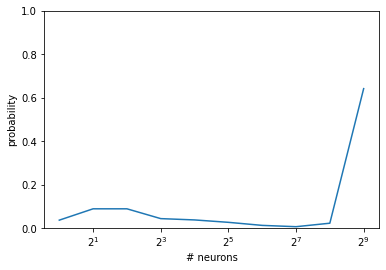

In [261]:
ax = sns.lineplot(x=x,y=y,markers=x)
from matplotlib.ticker import FixedLocator, PercentFormatter
xp = FixedLocator(x)
plt.gca().xaxis.set_major_locator(xp)
ax.set_ylim([0,1])
ax.set_xscale('log', basex=2)
ax.set_xlabel('# neurons')
ax.set_ylabel('probability')
ax

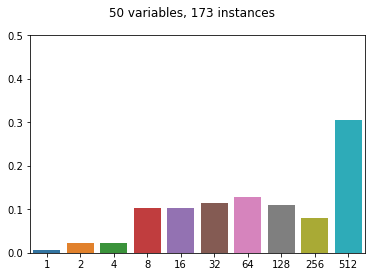

In [84]:
ax = sns.barplot(x=x,y=y)
plt.suptitle(f'50 variables, {len(grouped_df)} instances')
ax.set_ylim([0,.5])
ax

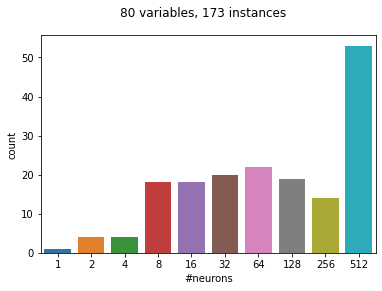

In [85]:
# now, I'll plot a count of how many formulas were mastered with each number of neurons
plt.figure()
sns.countplot(x="#neurons", data=grouped_df) #kudos: https://stackoverflow.com/a/58021306/1251716
plt.suptitle(f'80 variables, {len(grouped_df)} instances')
pass # holds the output of suptitle

In [86]:
base_dir = '/content/drive/My Drive/UFRGS/Learnability'

In [289]:
from glob import glob
import os
import re
from tqdm import tqdm

def extract_vars_from_path(input):
  regex = r'neurons_(\w+)_v(\d+)_(\w+)_v\d+_c(\d+)_r(\d\.\d+)\.csv'
  pattern = re.compile(regex)
  activation, n_vars, pos, c, r = pattern.search(input).groups()
  return dict(activation=activation, vars=str(n_vars), phase=pos, clauses=int(c), ratio=float(r))

all_data = []  

for f in tqdm(glob(f'{base_dir}/**/*.csv',recursive=True)):
  reg = extract_vars_from_path(os.path.basename(f))
  df = pd.read_csv(f)
  df2 = df.where(df.sampler=='unigen')[['formula','activation','#neurons']].groupby(['formula','activation'], as_index=False).last()
  df3 = pd.DataFrame(df2['#neurons'].value_counts().reset_index())
  all_neurons = df3['#neurons'].sum()
  filtered_neurons = df3[df3['index'] < 512]['#neurons'].sum()    
  reg['learned'] = (all_neurons - filtered_neurons)/all_neurons  

  all_data.append(reg)

dt_out = pd.DataFrame.from_dict(all_data)

100%|██████████| 220/220 [00:08<00:00, 26.61it/s]


In [290]:
dt_out.to_pickle(f'{base_dir}/probabilities.pkl')
dt_out.head()

,activation,vars,phase,clauses,ratio,learned
0,relu,10,over,59,5.9,1.0
1,relu,10,onphase,55,5.5,1.0
2,relu,10,over,58,5.8,1.0
3,relu,10,under,51,5.1,1.0
4,relu,10,under,53,5.3,1.0


In [346]:
dt_out = pd.read_pickle(f'{base_dir}/probabilities.pkl')

In [339]:
dt_out.ratio.apply(['min', 'mean', 'median', 'max'])

min       3.787000
mean      4.472118
median    4.413500
max       6.000000
Name: ratio, dtype: float64

In [332]:
def normalized_between_units(data):
  return -1 + 2 * (data - np.min(data)) / (np.max(data) - np.min(data))

In [347]:
dt_out['ratio'] = normalized_between_units(dt_out['ratio']) * 5

**ATTENTION! Original distribution is not symmetrical**

In [348]:
dt_out.ratio.apply(['min', 'mean', 'median', 'max'])

min      -5.000000
mean     -1.904120
median   -2.169001
max       5.000000
Name: ratio, dtype: float64

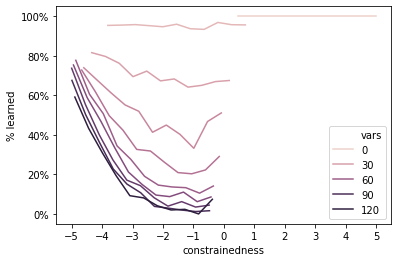

In [349]:
import matplotlib.ticker as mtick
g = sns.lineplot(x="ratio",y="learned", hue="vars", err_style=None, 
                data=dt_out)
g.yaxis.set_major_formatter(mtick.PercentFormatter(1))
g.set_xlabel('constrainedness')
g.set_ylabel('% learned')
g.set_xlim([-5.5,5.5])
g.set_xticks([x for x in range(-5,6)]);


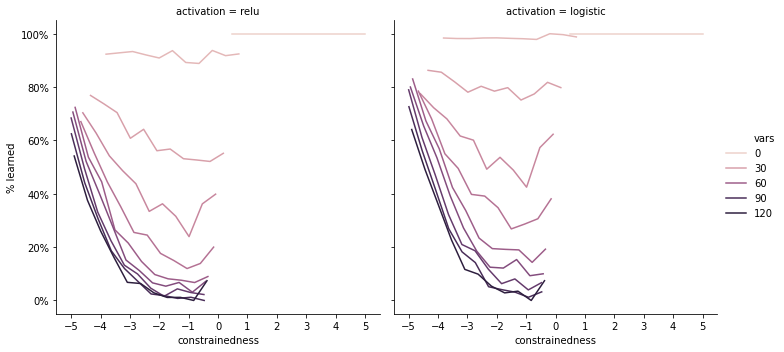

In [353]:
import matplotlib.ticker as mtick
grid = sns.relplot(x="ratio",y="learned", hue="vars", 
                   err_style=None, col="activation",
                   kind="line", data=dt_out)

for ax in grid.axes.flat:
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
  ax.xaxis.set_ticks([x for x in range(-5,6)]);

grid.set_xlabels('constrainedness')
grid.set_ylabels('% learned')

grid.set(xlim=[-5.5,5.5])

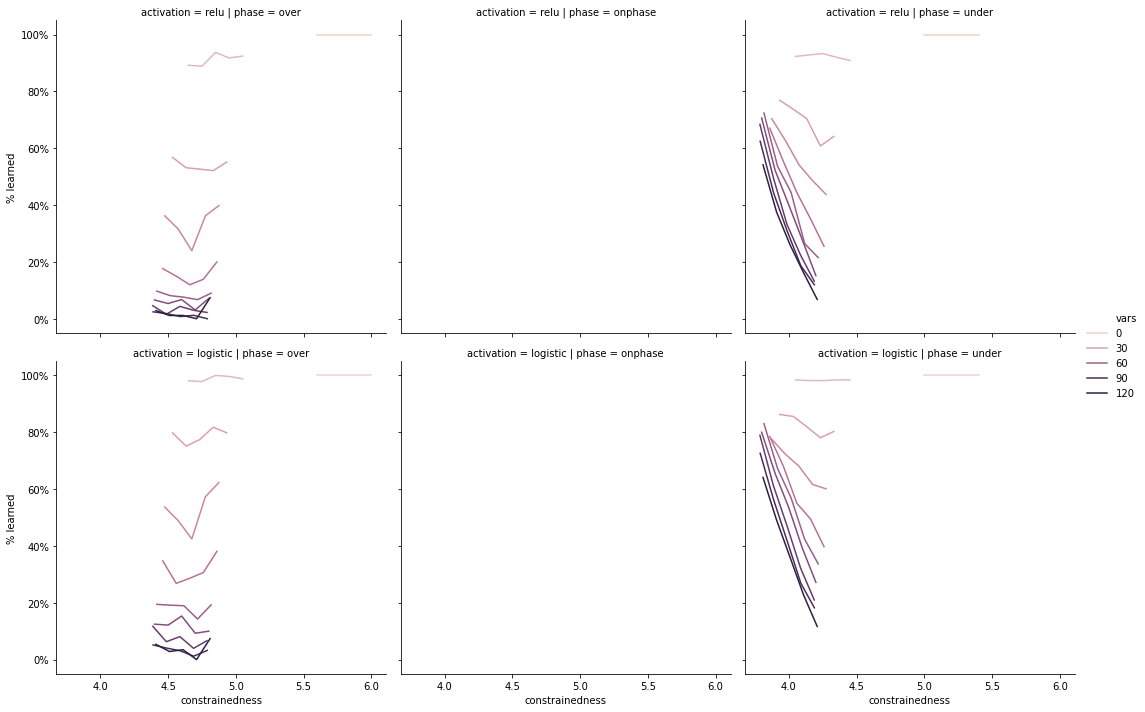

In [273]:
import matplotlib.ticker as mtick
grid = sns.relplot(x="ratio",y="learned", hue="vars", err_style=None, row="activation",
                   col="phase",
                kind="line", data=dt_out)

for ax in grid.axes.flat:
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

grid.set_xlabels('constrainedness')
grid.set_ylabels('% learned')

#grid.set(xlim=[-5,5])

## The problem is with multiple plots
Each will have a different number of instances (see code below), hence different y scales. I want the y axis in %

In [ ]:
import re
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns
import numpy as np

def dir_string_ratio(dir_str):
    """
    Extracts the ratio on a directory string.
    Useful for sorting in increasing difficulty
    """
    pattern = re.compile(r"r(\d\.\d+)\.csv")
    return float(pattern.search(dir_str).group(1))

def plot_num_neurons(basedir, num_vars, activation):

    for f in sorted(glob(f'{basedir}/neurons_{activation}_v{num_vars}_*.csv'), key=dir_string_ratio):
        df = pd.read_csv(f)
        #df = df[df.sampler == 'unigen']  # gets only instances with 40+ solutions
        grouped_df = df.where(df.sampler == 'unigen').groupby("formula").last().reset_index()
        df2 = df.where(df.sampler=='unigen').groupby('formula', 
                                                     sort=False, 
                                                     as_index=False).last()['#neurons'].value_counts(
                                                         normalize=True,
                                                         sort=False)
        idx = np.argsort(df2.index)
        x = df2.index[idx]
        y = df2.values[idx]                                             

        plt.figure()
        #sns.countplot(x="#neurons", data=grouped_df) #kudos: https://stackoverflow.com/a/58021306/1251716
        #ax = sns.lineplot(x=x,y=y)
        ax = sns.barplot(x=x,y=y)
        plt.suptitle(f'{os.path.basename(f)}, {len(grouped_df)} instances')
        ax.set_ylim([0,1])
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        #ax.set_xlim([0,515])
        ax
        #plt.show()
        #plt.savefig(f'/tmp/{g}_freq.pdf')



In [ ]:
plot_num_neurons('/content/drive/My Drive/UFRGS/Learnability/relu/', 80, 'relu')